## 1. Carga de datos y limpieza inicial

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
data_dir = 'results/'

In [3]:
#data = pd.read_csv(data_dir + 'GwasCat_associations.r2020-05-03.parsed.csv.gz')
data = pd.read_table(data_dir + 'gwas_cat.filtrado.tsv.gz')

In [4]:
data.head()

,fenotipo,alelo_riesgo,categoria_fenotipo,genes_reportados,genes_mapeados,contexto,OR_or_beta,gen_mapeado_elegido,EFO_URI
0,Crohn's disease,rs12722489-C,Digestive system disorder,IL2RA,IL2RA,intron,1.11,IL2RA,http://www.ebi.ac.uk/efo/EFO_0000384
1,Crohn's disease,rs151181-G,Digestive system disorder,IL27 | SH2B1 | EIF3C | LAT | CD19,CLN3 | AC138894.1,intron,1.07,CLN3,http://www.ebi.ac.uk/efo/EFO_0000384
2,Crohn's disease,rs2058660-G,Digestive system disorder,IL12RL2 | IL18R1 | IL1RL1 | IL18RAP,IL18RAP,intron,1.19,IL18RAP,http://www.ebi.ac.uk/efo/EFO_0000384
3,Crohn's disease,rs6556412-A,Digestive system disorder,IL12B,AC008691.1,intron,1.18,NaN,http://www.ebi.ac.uk/efo/EFO_0000384
4,Crohn's disease,rs2797685-A,Digestive system disorder,VAMP3,PER3 | Z98884.1,intron,1.05,PER3,http://www.ebi.ac.uk/efo/EFO_0000384


In [5]:
data.shape

(112626, 9)

Seleccionamos aquellas instancias que tienen en la columna `alelo_riesgo` un SNP.

In [7]:
mask_snps = data.alelo_riesgo.str.match("^rs[0-9]+-[ATCG\?]$")
data = data[mask_snps]
data.shape

(108556, 9)

Miramos y descartamos valores faltantes

In [8]:
data.isna().sum()

fenotipo                   0
alelo_riesgo               0
categoria_fenotipo        65
genes_reportados       42935
genes_mapeados          1727
contexto                1722
OR_or_beta                 0
gen_mapeado_elegido    46056
EFO_URI                   65
dtype: int64

No nos interesan aquellas instancias que tienen valore faltantes en la columna `OR_or_beta`

In [9]:
data.dropna(subset = ['OR_or_beta'], inplace = True)
data.shape

(108556, 9)

In [10]:
data.isna().sum()

fenotipo                   0
alelo_riesgo               0
categoria_fenotipo        65
genes_reportados       42935
genes_mapeados          1727
contexto                1722
OR_or_beta                 0
gen_mapeado_elegido    46056
EFO_URI                   65
dtype: int64

#### ESTO SE PUEDE MEJORAR: tiene que haber una única componente gigante

**Opcional 1**: sacamos aquellos alelos que aparezcan una sola vez. Sirve más que nada para achicar la base de datos.

In [11]:
if False:
    umbral = 1
    mask_alelos_poca_frecuencia = data.alelo_riesgo.value_counts() <=1
    mask_alelos_poca_frecuencia.head()

    alelos_poca_frecuencia = list(mask_alelos_poca_frecuencia.index[mask_alelos_poca_frecuencia.values])
    print(len(alelos_poca_frecuencia))

    mask_descartables = data.alelo_riesgo.isin(alelos_poca_frecuencia)
    mask_descartables

    print(data.shape)
    data = data[~mask_descartables]
    print(data.shape)

**Opcional 2:** Sacamos aquellos fenotipos que aparecen una sola vez:

In [12]:
umbral = 1
mask_fenotipos_poca_frecuencia = data.fenotipo.value_counts() <=1
mask_fenotipos_poca_frecuencia.head()

Blood protein levels                           False
Heel bone mineral density                      False
Height                                         False
Metabolite levels                              False
Educational attainment (years of education)    False
Name: fenotipo, dtype: bool

In [13]:
fenotipos_poca_frecuencia = list(mask_fenotipos_poca_frecuencia.index[mask_fenotipos_poca_frecuencia.values])
print(len(fenotipos_poca_frecuencia))

587


In [14]:
mask_descartables = data.fenotipo.isin(fenotipos_poca_frecuencia)
mask_descartables

0         False
1         False
2         False
3         False
4         False
          ...  
112621    False
112622    False
112623    False
112624    False
112625    False
Name: fenotipo, Length: 108556, dtype: bool

In [15]:
print(data.shape)
data = data[~mask_descartables]
print(data.shape)

(108556, 9)
(107969, 9)


### 2. Tripletes `alelo_riesgo`, `fenotipo` y `OR_or_beta` - Matriz de utilidad/¿incidencia?

In [16]:
data_tripletes = data[['alelo_riesgo', 'fenotipo', 'OR_or_beta']]
data_tripletes.shape

(107969, 3)

In [17]:
data_tripletes

,alelo_riesgo,fenotipo,OR_or_beta
0,rs12722489-C,Crohn's disease,1.1100
1,rs151181-G,Crohn's disease,1.0700
2,rs2058660-G,Crohn's disease,1.1900
3,rs6556412-A,Crohn's disease,1.1800
4,rs2797685-A,Crohn's disease,1.0500
...,...,...,...
112621,rs902627-A,Highest math class taken (MTAG),0.0095
112622,rs3117582-C,Lung adenocarcinoma,1.2200
112623,rs1051730-T,Lung adenocarcinoma,1.3100
112624,rs31489-C,Lung adenocarcinoma,1.1200


**Matriz de Utilidad/¿incidencia?**

In [18]:
n_alelos = data_tripletes.alelo_riesgo.nunique()
n_fenotipos = data_tripletes.fenotipo.nunique()

data_bipartita = pd.DataFrame(np.zeros((n_alelos, n_fenotipos)), columns = data_tripletes.fenotipo.value_counts().index, dtype = np.int8)
data_bipartita.head()

,Blood protein levels,Heel bone mineral density,Height,Metabolite levels,Educational attainment (years of education),Body mass index,Post bronchodilator FEV1/FVC ratio,Educational attainment (MTAG),General cognitive ability,Post bronchodilator FEV1,...,Paediatric migraine,Oligoclonal band status in multiple sclerosis,IgE levels in asthmatics (D.f. specific),Immunoglobulin G index levels in multiple sclerosis,Menstruation quality of life impact (fever),Cleft lip,Waist-to-hip ratio adjusted for BMI (additive genetic model),Drug-induced liver injury (amoxicillin-clavulanate),"Cortical brain region measurements (area, volume and thickness)",Spontaneous preterm birth (preterm delivery)
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
### EN EL DICCIONARIO APARECEN ORDENADOS POR FRECUENCIA
dict_id_to_alelo = {}
for i,alelo in enumerate(data_tripletes.alelo_riesgo.value_counts().index):
    dict_id_to_alelo[i] = alelo
    
dict_alelo_to_id = {v: k for k, v in dict_id_to_alelo.items()}

In [20]:
for _, row in data_tripletes.iterrows():
    alelo_row = row.alelo_riesgo
    fenotipo_row = row.fenotipo
    id_alelo = dict_alelo_to_id[alelo_row]
    data_bipartita.loc[id_alelo, fenotipo_row] = 1

**Chequeos**

La suma de todos los elementos de `data_bipartita` debe dar la cantidad de filas en `data_tripletes`

In [21]:
data_bipartita.sum().sum() == data_tripletes.shape[0]

True

La suma por columnas el `value_counts()` de `data_tripletes.fenotipo`

In [22]:
(data_tripletes.fenotipo.value_counts().values == data_bipartita.sum().values).all()

True

La suma por filas el `value_counts()` de `data_tripletes.alelo_riesgo`

In [23]:
(data_tripletes.alelo_riesgo.value_counts().values == data_bipartita.sum(axis = 1).values).all()

True

In [24]:
data_bipartita

,Blood protein levels,Heel bone mineral density,Height,Metabolite levels,Educational attainment (years of education),Body mass index,Post bronchodilator FEV1/FVC ratio,Educational attainment (MTAG),General cognitive ability,Post bronchodilator FEV1,...,Paediatric migraine,Oligoclonal band status in multiple sclerosis,IgE levels in asthmatics (D.f. specific),Immunoglobulin G index levels in multiple sclerosis,Menstruation quality of life impact (fever),Cleft lip,Waist-to-hip ratio adjusted for BMI (additive genetic model),Drug-induced liver injury (amoxicillin-clavulanate),"Cortical brain region measurements (area, volume and thickness)",Spontaneous preterm birth (preterm delivery)
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89454,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
89455,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
89456,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
89457,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Distribución de grado para fenotipos**

(array([920., 569., 573., 421., 216., 119.,  88.,  26.,  17.,   8.]),
 array([0.69314718, 1.41489152, 2.13663587, 2.85838021, 3.58012455,
        4.3018689 , 5.02361324, 5.74535758, 6.46710193, 7.18884627,
        7.91059061]),
 <a list of 10 Patch objects>)

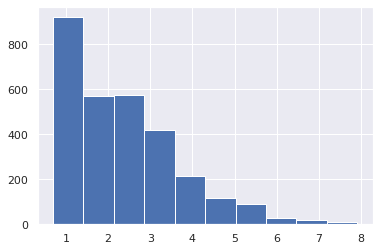

In [27]:
plt.hist(np.log(data_bipartita.sum()))

**Distribución de grado para alelos**

(array([8.8714e+04, 5.9400e+02, 9.9000e+01, 3.4000e+01, 1.0000e+01,
        2.0000e+00, 4.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 1. ,  4.5,  8. , 11.5, 15. , 18.5, 22. , 25.5, 29. , 32.5, 36. ]),
 <a list of 10 Patch objects>)

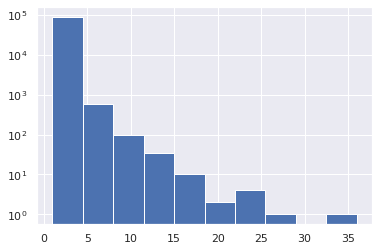

In [32]:
plt.hist(data_bipartita.sum(axis = 1), log=True)

¿VALE LA PENA ESTUDIAR ESTAS DISTRIBUCIONES?

### Separación de datos para testeo

#### Separación 1 - Alelos "nuevos"

Tomamos alelos al azar y los sacamos de la matriz de utilidad. De esta forma, no aportarán a las similitudes de los fenotipos.

Vamos a sacar alelos que tengan al menos grado 3 y como máximo grado 5 

In [52]:
np.random.seed(42)
n_alelos_a_sacar = 100
alelos_a_sacar = []

lista_alelos_desordenada = list(dict_id_to_alelo.keys())
lista_alelos_desordenada = np.random.choice(lista_alelos_desordenada,len(lista_alelos_desordenada), replace = False)

grados = data_bipartita.sum(axis = 1)
for alelo in lista_alelos_desordenada:
#     pass
    grado = grados.iloc[alelo]
    
    if grado >=3 and grado <=5:
        alelos_a_sacar.append(alelo)
        
    if len(alelos_a_sacar) == n_alelos_a_sacar:
        break

In [53]:
data_bipartita_test_1 = data_bipartita.iloc[alelos_a_sacar,:]
print(data_bipartita_test_1.shape)
print(data_bipartita_test_1.sum().sum())

(100, 2957)
345


In [54]:
data_bipartita_train = data_bipartita.drop(alelos_a_sacar)
print(data_bipartita_train.shape)

(89359, 2957)


#### ESTO SE PUEDE MEJORAR, PERO POR AHORA CHEQUEAMOS QUE NO QUEDE UN FENOTIPO DE GRADO 1
Nuevamente, lo mejor sería que el conjunto de train tenga una única componente.

In [55]:
data_bipartita_train.sum().min()

2

Sacamos del conjunto de test algunos fenotipos conocidos, hasta que quede un solo fenotipo conocido. ¿ESTUDIAR EN FUNCION DE ESTE HIPERPARÁMETRO?

In [56]:
np.random.seed(42)
n_fenotipos_a_dejar = 1

for idx, row in data_bipartita_test_1.iterrows():
    
    fenotipos_asociados = list(row[row == 1].index)
    fenotipos_asociados = np.random.choice(fenotipos_asociados, len(fenotipos_asociados), replace = False)
    contador = 0
    for fenotipo in fenotipos_asociados:
        data_bipartita_test_1.loc[idx, fenotipo] = 0
        contador +=1
        if contador == len(fenotipos_asociados) - n_fenotipos_a_dejar:
            break

<ipython-input-56-ff9eddc036ac>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_bipartita_test_1.loc[idx, fenotipo] = 0


In [57]:
data_bipartita_test_1.sum().sum()

100

### 3. Armamos la red --> ¿Pasar a Gephy la visualización?

Se puede saltear por ahora, no lo usamos

In [ ]:
import networkx as nx

In [ ]:
red = nx.Graph()

In [ ]:
red.add_edges_from(data_tripletes[['alelo_riesgo', 'fenotipo']].values)

In [ ]:
### MUY PESADO EN MEMORIA
matriz_adyacencia = nx.to_pandas_adjacency(red, dtype = np.int8)

In [ ]:
# prueba = np.ones((99365, 99365), dtype = np.uint8)
# del prueba

In [ ]:
matriz_adyacencia

In [ ]:
data_bipartita

### 4. Filtro Colaborativo Implícito

https://medium.com/radon-dev/item-item-collaborative-filtering-with-binary-or-unary-data-e8f0b465b2c3

In [58]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

En primer lugar, normalizamos con respecto a la cantidad de enlaces que tiene cada alelo. En las películas, esto se justifica como 

> *This is the idea of normalizing the user vectors so that a user with many ratings contributes less to any individual rating. This is to say that a like from a user who has only liked 10 items is more valuable to us than a like from someone who likes everything she comes across.*

In [59]:
#------------------------
# ITEM-ITEM CALCULATIONS
#------------------------

# As a first step we normalize the user vectors to unit vectors.

# magnitude = sqrt(x2 + y2 + z2 + ...)
magnitude = np.sqrt(np.square(data_bipartita_train).sum(axis=1))

# # unitvector = (x / magnitude, y / magnitude, z / magnitude, ...)
data_bipartita_normalizada = data_bipartita_train.divide(magnitude, axis='index')
data_bipartita_normalizada

,Blood protein levels,Heel bone mineral density,Height,Metabolite levels,Educational attainment (years of education),Body mass index,Post bronchodilator FEV1/FVC ratio,Educational attainment (MTAG),General cognitive ability,Post bronchodilator FEV1,...,Paediatric migraine,Oligoclonal band status in multiple sclerosis,IgE levels in asthmatics (D.f. specific),Immunoglobulin G index levels in multiple sclerosis,Menstruation quality of life impact (fever),Cleft lip,Waist-to-hip ratio adjusted for BMI (additive genetic model),Drug-induced liver injury (amoxicillin-clavulanate),"Cortical brain region measurements (area, volume and thickness)",Spontaneous preterm birth (preterm delivery)
0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.2,0.0,0.0,0.0,0.0,0.200000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.2,0.000000,0.0,0.2,0.2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89454,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89455,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89456,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89457,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Luego,calculamos la similaridad coseno para cada columna, obteniendo así qué fenotipos son parecidos.

In [60]:
def calculate_similarity(data_items):
    """Calculate the column-wise cosine similarity for a sparse
    matrix. Return a new dataframe matrix with similarities.
    """
    data_sparse = sparse.csr_matrix(data_items)
    similarities = cosine_similarity(data_sparse.transpose())
    sim = pd.DataFrame(data=similarities, index= data_items.columns, columns= data_items.columns)
    return sim

# Build the similarity matrix
data_matrix = calculate_similarity(data_bipartita_normalizada)
data_matrix.head()

,Blood protein levels,Heel bone mineral density,Height,Metabolite levels,Educational attainment (years of education),Body mass index,Post bronchodilator FEV1/FVC ratio,Educational attainment (MTAG),General cognitive ability,Post bronchodilator FEV1,...,Paediatric migraine,Oligoclonal band status in multiple sclerosis,IgE levels in asthmatics (D.f. specific),Immunoglobulin G index levels in multiple sclerosis,Menstruation quality of life impact (fever),Cleft lip,Waist-to-hip ratio adjusted for BMI (additive genetic model),Drug-induced liver injury (amoxicillin-clavulanate),"Cortical brain region measurements (area, volume and thickness)",Spontaneous preterm birth (preterm delivery)
Blood protein levels,1.000000,0.000000,0.000444,0.000000,0.000000,0.000685,0.00014,0.000000,0.000000,0.000522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Heel bone mineral density,0.000000,1.000000,0.002304,0.000240,0.000190,0.000173,0.00000,0.000586,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Height,0.000444,0.002304,1.000000,0.000078,0.000323,0.000755,0.00022,0.000400,0.000000,0.000274,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Metabolite levels,0.000000,0.000240,0.000078,1.000000,0.000336,0.000000,0.00000,0.000000,0.000352,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Educational attainment (years of education),0.000000,0.000190,0.000323,0.000336,1.000000,0.001714,0.00000,0.281039,0.003334,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Veamos similaridades

In [61]:
# Lets get the top 11 similar artists for Beyonce
# print(data_matrix.loc['Drinking behavior'].nlargest(25))

print(data_matrix.loc['Educational attainment (MTAG)'].nlargest(30))

Educational attainment (MTAG)                                                     1.000000
Educational attainment (years of education)                                       0.281039
Highest math class taken (MTAG)                                                   0.148034
Cognitive performance (MTAG)                                                      0.061834
Self-reported math ability (MTAG)                                                 0.020381
Intelligence (MTAG)                                                               0.011061
Household income (MTAG)                                                           0.009003
Cognitive performance                                                             0.007239
Highest math class taken                                                          0.006983
Intelligence                                                                      0.006981
Urea levels                                                                       0.004805

Construimos una nueva matriz, con los `n_neighbours` de cada fenotipo. Vendrían a ser los `n_neighbours` fenotipos más cercanos a cada fenotipos.

In [63]:
n_neighbours = 20
data_neighbours = pd.DataFrame(index=data_matrix.columns, columns=range(1,n_neighbours+1))
for i in range(0, len(data_matrix.columns)):
    data_neighbours.iloc[i,:n_neighbours] = data_matrix.iloc[0:,i].sort_values(ascending=False)[:n_neighbours].index
data_neighbours.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Blood protein levels,Blood protein levels,Planum temporale asymmetry index,Soluble levels of adhesion molecules,L-arginine levels,Insulinogenic index,Neovascular age-related macular degeneration,NT-proBNP levels in acute coronary syndrome,ADAMTS13 activity,B-type natriuretic peptide levels,Neonatal cytokine/chemokine levels (fetal gene...,Butyrylcholinesterase levels,Blood protein levels in cardiovascular risk,Expressive vocabulary in infants,Metabolic traits,Age-related macular degeneration (choroidal ne...,HIV-1 susceptibility,Composite immunoglobulin trait (IgA/IgG),Serum cancer antigen 19.9 levels,Serum protein levels (sST2),IgE levels
Heel bone mineral density,Heel bone mineral density,Serum sclerostin levels,Fractures,Thyroid function,Systolic blood pressure change trajectories,Multisite chronic pain,Cardiovascular disease risk factors,Total body bone mineral density,Systemic lupus erythematosus or rheumatoid art...,Height,Heel bone mineral density (MTAG),Total body bone mineral density (MTAG),Maternal nondisjunction of chromosome 21 (MI e...,Serum alkaline phosphatase levels,Stem cell factor levels,Lumbar spine bone mineral density (trabecular),Femoral neck bone mineral density,Maternal nondisjunction of chromosome 21 (moth...,Educational attainment (college completion),Pulmonary function
Height,Height,Infant length,Birth length,Hip circumference adjusted for BMI,Puberty onset (breast development),Waist circumference adjusted for BMI in non-sm...,Glucagon levels in response to oral glucose to...,Waist circumference adjusted for BMI (adjusted...,Developmental dysplasia of the hip,Birth weight,Waist circumference adjusted for BMI in active...,Age at voice drop,Anthropometric traits,Head circumference (infant),Infant head circumference (MTAG),Weight,Waist circumference adjusted for body mass index,Body fat distribution (arm fat ratio),Birth weight (MTAG),Menarche and menopause (age at onset)
Metabolite levels,Metabolite levels,Parkinson's disease in GBA mutation carriers,Statin-induced myopathy (severe),Red blood cell fatty acid levels,Serum urea levels,Fasting blood glucose,Acylcarnitine levels,Urinary sodium to creatinine ratio,Plasma factor V levels in venous thrombosis (c...,Lipoprotein-associated phospholipase A2 activi...,Plasma free amino acid levels (adjusted for tw...,Folate pathway vitamin levels,Change in serum metabolite levels,QRS interval (sulfonylurea treatment interaction),Hematological and biochemical traits,Change in serum metabolite levels (CMS),Serum metabolite levels,Alanine transaminase levels,Total bilirubin levels in HIV-1 infection,Low HDL-cholesterol levels
Educational attainment (years of education),Educational attainment (years of education),Educational attainment (MTAG),Highest math class taken (MTAG),Cognitive performance (MTAG),Household income (MTAG),Intelligence (MTAG),Self-reported math ability (MTAG),Educational attainment (college completion),Autism and major depressive disorder (MTAG),Risk-taking tendency (4-domain principal compo...,Intelligence,Smoking behaviour (cigarette pack-years),Urea levels,Cigarettes smoked per day (MTAG),Regular attendance at a gym or sports club,Eating disorders,Alcohol consumption,Educational attainment,Cognitive performance,General cognitive ability


Elegimos un alelo dentro del conjunto de entrenamiento

In [99]:
# np.random.seed(43)
alelo_prueba = np.random.choice(data_tripletes.alelo_riesgo.unique())
# alelo_prueba = 'rs6739779-C'
print(f'Alelo de prueba: {alelo_prueba}')

alelo_prueba_index = dict_alelo_to_id[alelo_prueba]
print(f'Indice del alelo de prueba: {alelo_prueba_index}')

known_alelo_fenotipos = data_bipartita_normalizada.iloc[alelo_prueba_index]
known_alelo_fenotipos = known_alelo_fenotipos[known_alelo_fenotipos >0].index.values
print(f'Fenotipos asociados al alelo: {known_alelo_fenotipos}')

Alelo de prueba: rs34276187-T
Indice del alelo de prueba: 35292
Fenotipos asociados al alelo: ['General cognitive ability']


Dado esos fenotipos, seleccionamos los similares a partir de `data_neighbours`

In [100]:
# Construct the neighbourhood from the most similar items to the
# ones our alelo it's related
most_similar_fenotipos = data_neighbours.loc[known_alelo_fenotipos]
# most_similar_fenotipos
similar_list = most_similar_fenotipos.values.tolist()
similar_list = list(set([item for sublist in similar_list for item in sublist]))
print(f'Fenotipos similares, sin rankear: {similar_list}')

Fenotipos similares, sin rankear: ['Mental health study participation (provided email address)', 'Cognitive ability, years of educational attainment or schizophrenia (pleiotropy)', 'Brainstem volume', 'Cognitive performance', 'Cognitive performance (MTAG)', 'Allergy', 'Autism and educational attainment (MTAG)', 'Verbal-numerical reasoning', 'General factor of neuroticism', 'Waist circumference adjusted for BMI (adjusted for smoking behaviour)', 'General cognitive ability', 'Intelligence', 'Cognitive ability', 'Educational attainment (MTAG)', 'Educational attainment (years of education)', 'Intelligence (MTAG)', 'Regular attendance at a religious group', 'vWF levels', 'Household income (MTAG)', 'Self-reported math ability (MTAG)']


Seleccionamos, dentro de la matriz de similaridades, los valores para los fenotipos similares

In [101]:
neighbourhood = data_matrix[similar_list].loc[similar_list]
neighbourhood.shape

(20, 20)

Creamos un vector que tiene los fenotipos similares, incluyendo los conocidos, y su *rating* (1 o 0).

In [102]:
# A user vector containing only the neighbourhood items and
# the known user likes.
fenotipos_probables = data_bipartita_normalizada.iloc[alelo_prueba_index].loc[similar_list]
fenotipos_probables

Mental health study participation (provided email address)                          0.0
Cognitive ability, years of educational attainment or schizophrenia (pleiotropy)    0.0
Brainstem volume                                                                    0.0
Cognitive performance                                                               0.0
Cognitive performance (MTAG)                                                        0.0
Allergy                                                                             0.0
Autism and educational attainment (MTAG)                                            0.0
Verbal-numerical reasoning                                                          0.0
General factor of neuroticism                                                       0.0
Waist circumference adjusted for BMI (adjusted for smoking behaviour)               0.0
General cognitive ability                                                           1.0
Intelligence                    

Calculamos los scores y ordenamos.

In [103]:
# Calculate the score.
score = neighbourhood.dot(fenotipos_probables).div(neighbourhood.sum(axis=1))
# score
score.sort_values(ascending = False, inplace = True)
# score

E imprimimos los fenotipos conocidos y el ranking

In [104]:
print(known_alelo_fenotipos)
print(score)

['General cognitive ability']
General cognitive ability                                                           0.853919
Intelligence (MTAG)                                                                 0.029415
Intelligence                                                                        0.028101
Cognitive performance                                                               0.017461
Cognitive performance (MTAG)                                                        0.008403
Verbal-numerical reasoning                                                          0.008105
Autism and educational attainment (MTAG)                                            0.006002
General factor of neuroticism                                                       0.004965
Cognitive ability                                                                   0.004251
Mental health study participation (provided email address)                          0.004158
Waist circumference adjusted for BMI (ad

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text xticklabel objects>)

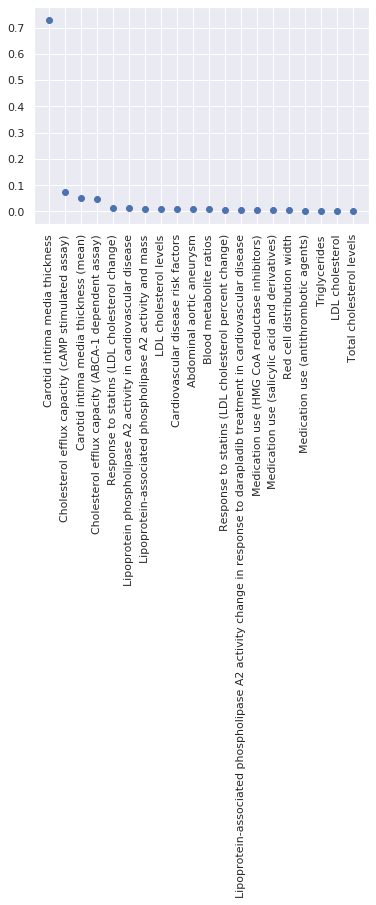

In [98]:
# sns.barplot(score.index, score.values)
plt.scatter(score.index, score.values)
plt.xticks(rotation = 90)

In [ ]:
def recomendaciones_alelo():
    known_alelo_fenotipos = data_bipartita_normalizada.iloc[alelo_prueba_index]
    known_alelo_fenotipos = known_alelo_fenotipos[known_alelo_fenotipos >0].index.values

    most_similar_fenotipos = data_neighbours.loc[known_alelo_fenotipos]

    similar_list = most_similar_fenotipos.values.tolist()
    similar_list = list(set([item for sublist in similar_list for item in sublist]))

    neighbourhood = data_matrix[similar_list].loc[similar_list]

    fenotipos_probables = data_bipartita_normalizada.iloc[alelo_prueba_index].loc[similar_list]
    fenotipos_probables

    score = neighbourhood.dot(fenotipos_probables).div(neighbourhood.sum(axis=1))
    score.sort_values(ascending = False, inplace = True)


    return score

In [98]:

    known_alelo_fenotipos = data_bipartita_normalizada.iloc[alelo_prueba_index]
    known_alelo_fenotipos = known_alelo_fenotipos[known_alelo_fenotipos >0].index.values

    most_similar_fenotipos = data_neighbours.loc[known_alelo_fenotipos]

    similar_list = most_similar_fenotipos.values.tolist()
    similar_list = list(set([item for sublist in similar_list for item in sublist]))

    neighbourhood = data_matrix[similar_list].loc[similar_list]

    fenotipos_probables = data_bipartita_normalizada.iloc[alelo_prueba_index].loc[similar_list]
    fenotipos_probables

    score = neighbourhood.dot(fenotipos_probables).div(neighbourhood.sum(axis=1))
    score.sort_values(ascending = False, inplace = True)


    return score

# sns.barplot(score.index, score.values)
plt.scatter(score.index, score.values)
plt.xticks(rotation = 90)

### Sobre Conjunto de Test

"A mano" por ahora

In [ ]:
# np.random.seed(50)
alelo_prueba_index = np.random.choice(data_bipartita_test_1.index)
alelo_prueba_index

In [ ]:
alelo_prueba = dict_id_to_alelo[alelo_prueba_index]
alelo_prueba

In [ ]:
known_alelo_fenotipos = data_bipartita_test_1.loc[alelo_prueba_index]
known_alelo_fenotipos = known_alelo_fenotipos[known_alelo_fenotipos >0].index.values
print(known_alelo_fenotipos)

In [ ]:
fenotipos_reportados_alelo = data_bipartita.loc[alelo_prueba_index]
fenotipos_reportados_alelo = fenotipos_reportados_alelo[fenotipos_reportados_alelo >0].index.values
print(fenotipos_reportados_alelo)

In [ ]:
# Construct the neighbourhood from the most similar items to the
# ones our alelo it's related
most_similar_fenotipos = data_neighbours.loc[known_alelo_fenotipos]
most_similar_fenotipos

In [ ]:
similar_list = most_similar_fenotipos.values.tolist()
similar_list = list(set([item for sublist in similar_list for item in sublist]))
similar_list


In [ ]:
neighbourhood = data_matrix[similar_list].loc[similar_list]
neighbourhood

In [ ]:
data_bipartita_test_1.loc[alelo_prueba_index]

In [ ]:
# A user vector containing only the neighbourhood items and
# the known user likes.
fenotipos_probables = data_bipartita_test_1.loc[alelo_prueba_index].loc[similar_list]
fenotipos_probables

In [ ]:
# Calculate the score.
score = neighbourhood.dot(fenotipos_probables).div(neighbourhood.sum(axis=1))
score

In [ ]:
# Drop the known likes.
# score = score.drop(known_alelo_fenotipos).sort_values()
score.sort_values(ascending = False, inplace = True)
score

In [ ]:
print(known_alelo_fenotipos)
print(fenotipos_reportados_alelo)
print(score.nlargest(50))

grafico de fenotipos vs score
capacidad de priorizar dado 
Usar el paper de zhou


MARTES - 5 min
dimensión de los datos
encuadrar el problema biológico o metodológico



### Cosas para hacer

1. Chequear sobre `categoria_fenotipo` que no sea trivial
1. Agregar segunda forma de evaluación: borrando '1' de la matriz de train
1. Chequear que al separar train y test no se rompa la red
1. Metodizar la evaluación para obtener una métrica
1. Chequear que no estemos cayendo en la parte "fácil" de la red --> ¿pregunta biológica?